In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gaussian_process import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,hour,day_of_week,month,year,is_holiday,time_step
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,9,1,10,2012,0,0
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,10,1,10,2012,0,1
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,11,1,10,2012,0,2
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,12,1,10,2012,0,3
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,13,1,10,2012,0,4


In [3]:
df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")
df['date_time'] = pd.to_datetime(df['date_time'])
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek
df['month'] = df['date_time'].dt.month
df['year'] = df['date_time'].dt.year
df['is_holiday'] = (~ df['holiday'].isnull()).astype(int)

df['time_step'] = (df['date_time'] - pd.Timestamp("2012-10-02 09:00:00")) // pd.Timedelta(hours=1)

# Training data
df_train = df[df['date_time'].dt.year.isin([2016, 2017])] # 2016 and earlier as training data
df_test = df[df['date_time'].dt.year.isin([2018])] # validation on test data

# include holiday and weather variables
#X_train = df_train[['time_step', 'is_holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all']]
#X_test = df_test[['time_step', 'is_holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all']]
X_train = df_train[['time_step', 'is_holiday']]
X_test = df_test[['time_step', 'is_holiday']]



y_train = df_train['traffic_volume']
y_test = df_test['traffic_volume']

In [86]:
print(len(X_train))
print(len(X_test))

19911
7949


In [5]:
sigma = 1e-8
K = periodic_kernel(X_train, X_train, period = 7*24)
K_noisy = K + sigma * np.eye(len(X_train)) # kernel fcn between train data 
b = periodic_kernel(X_train, X_test, period = 7*24) # kernel fcn between train and test data
# Kernel of observations vs to-predict

In [ ]:

solved = scipy.linalg.solve(K_noisy, b, assume_a='pos').T
test_pred = solved @ y_test

LinAlgError: Matrix is singular.

In [9]:
def periodic_kernel_test(X, Y=None, length_scale=1.0, period=1.0):
    """
    Compute the Gram matrix using the periodic kernel.

    Parameters:
    - X: ndarray of shape (n_samples, n_features)
    - Y: optional, ndarray of shape (m_samples, n_features). If None, Y = X.
    - length_scale: float, the length scale (ℓ)
    - period: float, the period (p)

    Returns:
    - K: Gram matrix of shape (n_samples, m_samples)
    """
    if Y is None:
        Y = X
    X = np.atleast_2d(X)
    Y = np.atleast_2d(Y)

    # Compute the L2 distance matrix
    dists = np.linalg.norm(X[:, None, :] - Y[None, :, :], axis=2)

    # Apply the periodic kernel
    K = np.exp(-2 * (np.sin(np.pi * dists / period) ** 2) / length_scale**2)
    return K

In [ ]:
def periodic_kernel(X1, X2, lengthscale=1.0, period=1.0):
    X1 = np.atleast_2d(X1)
    X2 = np.atleast_2d(X2)
    
    # Ensure lengthscale and period are arrays with shape (d,)
    lengthscale = np.atleast_1d(lengthscale)
    period = np.atleast_1d(period)
    
    if lengthscale.size == 1:
        lengthscale = np.full(X1.shape[1], lengthscale)
    if period.size == 1:
        period = np.full(X1.shape[1], period)

    # Compute Gram matrix
    K = np.zeros((X1.shape[0], X2.shape[0]))
    for d in range(X1.shape[1]):
        x1_d = X1[:, d][:, None]
        x2_d = X2[:, d][None, :]
        dist = np.abs(x1_d - x2_d)
        sin_term = np.sin(np.pi * dist / period[d]) ** 2
        K += -2 * sin_term / lengthscale[d]**2
    return np.exp(K)


In [12]:
K1

array([[1.        , 1.        , 0.93448514, ..., 0.74610574, 0.87461555,
        0.96650168],
       [1.        , 1.        , 0.93448514, ..., 0.74610574, 0.87461555,
        0.96650168],
       [0.93448514, 0.93448514, 1.        , ..., 0.60653066, 0.74610181,
        0.87461228],
       ...,
       [0.74610574, 0.74610574, 0.60653066, ..., 1.        , 0.96649981,
        0.87461228],
       [0.87461555, 0.87461555, 0.74610181, ..., 0.96649981, 1.        ,
        0.96649981],
       [0.96650168, 0.96650168, 0.87461228, ..., 0.87461228, 0.96649981,
        1.        ]], shape=(19911, 19911))

In [13]:
K2

array([[1.        , 1.        , 0.15595057, ..., 0.99999998, 0.99999998,
        0.99999998],
       [1.        , 1.        , 0.15595057, ..., 0.99999998, 0.99999998,
        0.99999998],
       [0.15595057, 0.15595057, 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.99999998, 0.99999998, 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.99999998, 0.99999998, 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.99999998, 0.99999998, 1.        , ..., 1.        , 1.        ,
        1.        ]], shape=(19911, 19911))

In [15]:
np.linalg.cholesky(K2)

LinAlgError: Matrix is not positive definite

In [28]:
X_tst = np.array([
    [1, 0],
    [2, 0],
    [3, 0],
    [4, 1],
    [5, 0],
])

In [97]:
K = rbf_kernel(X_train, X_train)

In [98]:
L = np.linalg.cholesky(K + 1e-8 * np.eye(len(X_train)))

In [85]:
# 15m 36.4s
# 13m 57.7s (2015, 16, 17, 18)
mu_test, cov_test, mu_train, cov_train, K, K_inv = gp_posterior(X_train, y_train, X_test, periodic_kernel, period = 7*24) # period = 7 days, length scale = 1

# 50s (17, 18)
# 6m (16, 17, 18)

Computing Gram Matrix


KeyboardInterrupt: 

In [ ]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(X_test['time_step'], y_test, 'ro', label='Test Data')

plt.plot(X_test['time_step'], mu_test, 'b-', label='Predictive Mean')
plt.fill_between(X_test['time_step'], lower, upper, color='blue', alpha=0.5, label='Confidence Interval (95%)')
plt.title(f"Periodic Kernel, length = {l}, period = 7d")
plt.legend()
plt.show()

In [ ]:
# testing kernel gradient function

def kernel_gradients(X, alpha, lengthscale, period):
    """
    Returns the derivatives of the periodic kernel matrix K(X, X) w.r.t.
    alpha, lengthscale, and period.
    """
    X = np.atleast_2d(X)
    print(X.shape)
    X = X.reshape(-1, 1)
    dists = np.abs(X - X.T)
    sine_arg = np.pi * dists / period
    sin_sq = np.sin(sine_arg)**2
    cos_vals = np.cos(sine_arg)

    K = alpha * np.exp(-2 * sin_sq / lengthscale**2)

    dK_da = K / alpha # variance derivative (alpha)

    dK_dl = K * (4 * sin_sq) / (lengthscale**3) # length scale derivative

    dK_dp = (4 * np.pi * dists * alpha * np.exp(-2 * sin_sq / lengthscale**2)
                  * np.sin(sine_arg) * cos_vals) / (lengthscale**2 * period**2) # period derivative

    return K, dK_da, dK_dl, dK_dp


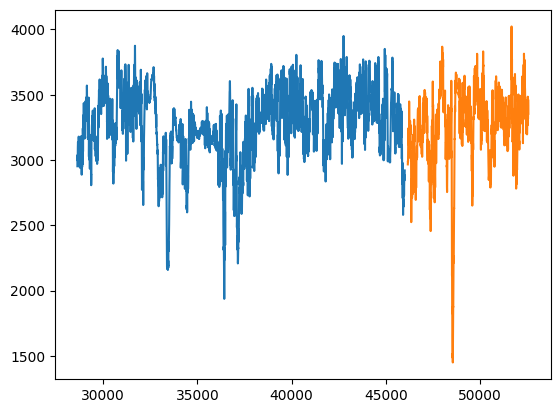

In [13]:
plt.plot(X_train['time_step'], y_train.rolling(window=7*24).mean()) # rolling 7 day avg
plt.plot(X_test['time_step'], y_test.rolling(window=7*24).mean())
plt.show()

In [91]:
lst_rmse = []
for l in [0.01, 0.1, 1, 10]:

    # learn gp model
    mu_s, cov_s = gp_posterior(X_train, y_train, X_test, periodic_kernel, length_scale = l, period = 7*24)

    stdv = np.sqrt(np.diag(cov_s))
    upper = mu_s + 2 * stdv
    lower = mu_s - 2 * stdv

    lst_rmse.append(rmse(y_test, mu_s))
    
    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(X_test['time_step'], y_test, 'ro', label='Test Data')

    plt.plot(X_test['time_step'], mu_s, 'b-', label='Predictive Mean')
    plt.fill_between(X_test['time_step'], lower, upper, color='blue', alpha=0.5, label='Confidence Interval (95%)')
    plt.title(f"Periodic Kernel, length = {l}, period = 7d")
    plt.legend()
    plt.show()

for i in range(4):
    print(f'RMSE: {lst_rmse[i]}')

: 

In [ ]:
def gp_posterior2(X_train, y_train, X_test, kernel, noise=1e-8, **kwargs):
    """Compute posterior mean and covariance of GP"""
    n = len(X_train)
    n_tst = len(X_test)

    print("Computing Gram Matrix")
    K = kernel(X_train, X_train, **kwargs)
    K_noisy = K + noise * np.eye(n) # kernel fcn between train data 
    b = kernel(X_train, X_test, **kwargs) # kernel fcn between train and test data
    c = kernel(X_test, X_test, **kwargs)# kernel fcn between test data

    print('Doing Cholesky Decomposition')
    #K_inv = np.linalg.inv(K_noisy) # inverting noisy gram matrix

    L = np.linalg.cholesky(K_noisy)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))



    print('Computing Mean and Covariance')
    mu_s = b.T @ alpha
    v = np.linalg.solve(L, b)
    cov_s = c - v.T @ v

    mu_tr = K.T @ alpha
    v = np.linalg.solve(L, K)
    cov_tr = c - v.T @ v

    mu_tr = K.T.dot(K_inv.dot(y_train))
    cov_tr = K - (K.T).dot(K_inv.dot(K))

    return mu_s, cov_s, mu_tr, cov_tr, K, K_inv

In [14]:
np.std(y_train)*0.05

np.float64(98.68393075442467)

In [15]:
n = len(X_train)
n_tst = len(X_test)

print("Computing Gram Matrix")
K = periodic_kernel(X_train, X_train)
K_noisy = K + 1 * np.eye(n) # kernel fcn between train data 
b = periodic_kernel(X_train, X_test) # kernel fcn between train and test data
c = periodic_kernel(X_test, X_test)# kernel fcn between test data

Computing Gram Matrix


In [16]:
print('Doing Cholesky Decomposition')

L = np.linalg.cholesky(K_noisy)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))

Doing Cholesky Decomposition


In [20]:
print('Computing Mean and Covariance')
mu_s = b.T @ alpha
v = np.linalg.solve(L, b)
cov_s = c - v.T @ v

Computing Mean and Covariance


In [ ]:
mu_tr = K.T @ alpha
v = np.linalg.solve(L, K)
cov_tr = K - v.T @ v

In [26]:
mu_s

array([ 927.27115961,  553.75977502,  289.46215198, ..., 2591.02884826,
       2158.24982053, 1520.46250007], shape=(7949,))

In [38]:
stdv = np.sqrt(np.abs(np.diag(cov_s)))
upper = mu_s + 2 * stdv
lower = mu_s - 2 * stdv

In [43]:
stdv

array([0.05029408, 0.02068125, 0.02073967, ..., 0.02115573, 0.02100543,
       0.02077491], shape=(7949,))

In [44]:
mu_s

array([ 927.27115961,  553.75977502,  289.46215198, ..., 2591.02884826,
       2158.24982053, 1520.46250007], shape=(7949,))

In [41]:
upper

array([ 927.37174776,  553.80113753,  289.50363132, ..., 2591.07115973,
       2158.29183139, 1520.5040499 ], shape=(7949,))

In [42]:
lower

array([ 927.17057145,  553.71841252,  289.42067265, ..., 2590.98653679,
       2158.20780967, 1520.42095025], shape=(7949,))

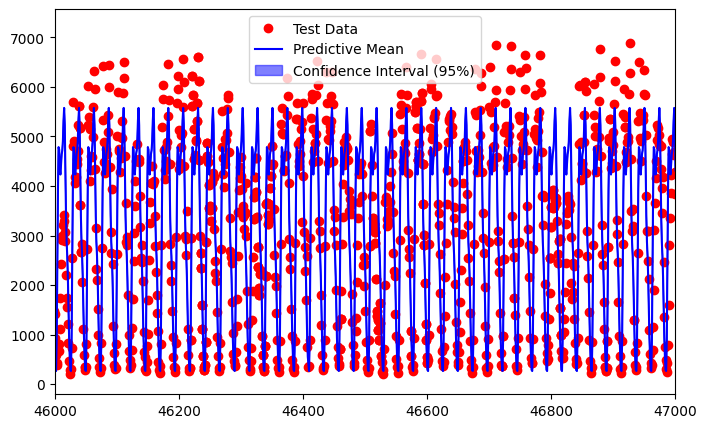

In [47]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(X_test['time_step'], y_test, 'ro', label='Test Data')

plt.plot(X_test['time_step'], mu_s, 'b-', label='Predictive Mean')
plt.fill_between(X_test['time_step'], lower, upper, color='blue', alpha=0.5, label='Confidence Interval (95%)')
#plt.title(f"Periodic Kernel, length = {l}, period = 7d")
plt.xlim(46000, 47000)
plt.legend()
plt.show()